In [1]:
import mxnet as mx
from mxnet import gluon as g
from mxnet import nd
import numpy as np
from mxnet import autograd as ag
from matplotlib import pyplot as plt
import os
import time

In [2]:
ctx = mx.gpu()

In [3]:
batch_size = 256
height = 32
width = 7*height

In [4]:
data_iter = mx.io.ImageRecordIter(path_imgrec=os.path.join('dataset','train_S.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

data_iter_val = mx.io.ImageRecordIter(path_imgrec=os.path.join('dataset','val_S.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

### training

In [5]:
class autoencoder(g.nn.Block):
    def __init__(self):
        super(autoencoder, self).__init__()
        with self.name_scope():       
            self.encodercnn = g.nn.HybridSequential('encoder_cnn_')
            with self.encodercnn.name_scope():
                self.encodercnn.add(g.nn.Conv2D(64, 3, strides=1, padding=1, activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,2), strides=2))
                self.encodercnn.add(g.nn.Conv2D(128, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,2), strides=2))
                self.encodercnn.add(g.nn.Conv2D(256, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.Conv2D(256, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=2))
                self.encodercnn.add(g.nn.Conv2D(512, 3, strides=1, padding=1))
                self.encodercnn.add(g.nn.BatchNorm(axis=1, center=True, scale=True))
                self.encodercnn.add(g.nn.Activation(activation='relu'))
                self.encodercnn.add(g.nn.Conv2D(512, 3, strides=1, padding=1))
                self.encodercnn.add(g.nn.BatchNorm(axis=1, center=True, scale=True))
                self.encodercnn.add(g.nn.Activation(activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=2))
                self.encodercnn.add(g.nn.Conv2D(512, 1, strides=1, padding=0,activation='relu'))
            
            self.encoderrnn = g.rnn.SequentialRNNCell('encoder_rnn_')
            with self.encoderrnn.name_scope():
                self.encoderrnn.add(g.rnn.LSTMCell(512))
                self.encoderrnn.add(g.rnn.LSTMCell(512))
            
            self.intermediate_nn = g.nn.Dense(512)
            #self.intermediate_nn1 = g.nn.Dense(512,activation='sigmoid')
            #self.intermediate_nn2 = g.nn.Dense(256,activation='sigmoid')
            #self.intermediate_nn3 = g.nn.Dense(512,activation='sigmoid')
            
            self.decoderrnn = g.rnn.SequentialRNNCell('decoder_rnn_')
            with self.decoderrnn.name_scope():
                self.decoderrnn.add(g.rnn.LSTMCell(512))
                self.decoderrnn.add(g.rnn.LSTMCell(512))
                
            self.decodercnn = g.nn.HybridSequential('decoder_cnn_')
            with self.decodercnn.name_scope():
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 1, strides=1, padding=0,activation='relu'))
                # upsampling (1,7)
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 3, strides=1, padding=1, activation='relu'))
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 3, strides=1, padding=1, activation='relu'))
                # upsampling (2,14)
                self.decodercnn.add(g.nn.Conv2DTranspose(256, 3, strides=1, padding=1,activation='relu'))
                self.decodercnn.add(g.nn.Conv2DTranspose(256, 3, strides=1, padding=1,activation='relu'))
                # upsampling (4,28)
                self.decodercnn.add(g.nn.Conv2DTranspose(128, 3, strides=1, padding=1,activation='relu'))
                # upsampling (8,56)
                self.decodercnn.add(g.nn.Conv2DTranspose(64, 3, strides=1, padding=1, activation='relu'))
                # upsampling (16,112)
                self.decodercnn.add(g.nn.Conv2DTranspose(3, 3, strides=1, padding=1, activation='tanh'))
    def forward(self, x):
        # encoder
        x = self.encodercnn(x)
        status = self.encoderrnn.begin_state(batch_size=batch_size,ctx=ctx)
        for i in range(x.shape[3]):
            cvector, status = self.encoderrnn(nd.flatten(x[:,:,:,i]), status)
        cvector = self.intermediate_nn(cvector)
        # decoder
        for i in range(x.shape[3]):
            cvector, status = self.decoderrnn(cvector, status)
            if i == 0:
                outputs = mx.nd.expand_dims(cvector, axis=2)
            else:
                outputs = mx.nd.concat(outputs,mx.nd.expand_dims(cvector, axis=2),dim=2)
        xs = mx.nd.Reshape(outputs,(x.shape[0],x.shape[1],1,x.shape[3]))
        for i in range(len(self.decodercnn)):
            xs = self.decodercnn[i](xs)
            if (i == 0):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=2, width=2*7)
            elif (i == 2):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=4, width=4*7)
            elif (i == 4):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=8, width=8*7)
            elif (i == 6):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=16, width=16*7)
            elif (i == 7):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=32, width=32*7)
        return xs*4

### Initialization for Optimization & Training

In [6]:
model = autoencoder()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
for batch in data_iter:
    batch
    break
print(model(batch.data[0].as_in_context(ctx)).shape)
model.save_parameters("process/ae_*.params")

(256L, 3L, 24L, 168L)


### Inference

In [7]:
criterion = g.loss.L2Loss()

### Optimization & Training

### Visualization

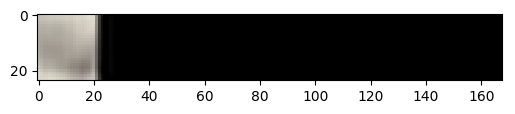

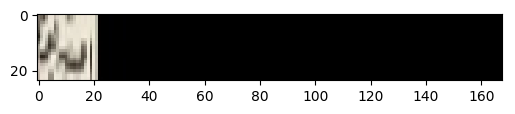

In [11]:
from random import randint
whichIm = randint(0,200)
for batch in data_iter_val:
    x = batch.data[0].as_in_context(ctx)
    y = model(x)
    break
val_image = y[whichIm,:,:,:].as_in_context(mx.cpu())
val_image = val_image.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
val_image = (val_image * 255).clip(0, 255)
val_image = val_image.asnumpy()
val_image = val_image.astype(np.uint8)
plt.rcParams["figure.dpi"] = 100
plt.imshow(val_image)
plt.savefig('val.png')
plt.show()
org = x[whichIm,:,:,:].as_in_context(mx.cpu())
org = org.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
org = (org * 255).clip(0, 255)
org = org.asnumpy()
org = org.astype(np.uint8)
plt.imshow(org)
plt.savefig('org.png')
plt.show()

In [10]:
from random import randint
whichIm = randint(0,200)
for batch in data_iter_val:
    x = batch.data[0].as_in_context(ctx)
    y = model(x)